# Crystal pattern recognition

Examples of using supervised machine learning techniques to classify crystal lattice types. Remark that the methods used here are definitely not the best, but hopefully instructive.

<strong>NanoKnitter 0.1</strong><br/>
Michael Barbier<br/>
May 25, 2020<br/>
[Simply Complex Lab](http://staff.bilkent.edu.tr/serim/)

## 1. Initialization

In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets, svm
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import Delaunay
from time import time
import argparse

# Personal modules
from mlpy import util, detection, mio, plots, patterns as pr

# Reload personal modules (see: https://docs.python.org/3.8/tutorial/modules.html)
import importlib

importlib.reload(util)
importlib.reload(mio)
importlib.reload(plots)
importlib.reload(detection)
importlib.reload(pr)

# Print the OpenCV version for debugging
print(cv.__version__)

# Increase the matplotlib figure size by increasing resolution
plt.rcParams['figure.dpi'] = 300

4.2.0


## 2. Training data
Shows maximum the first 10 data samples with annotation of the crystal type as a manual mask.

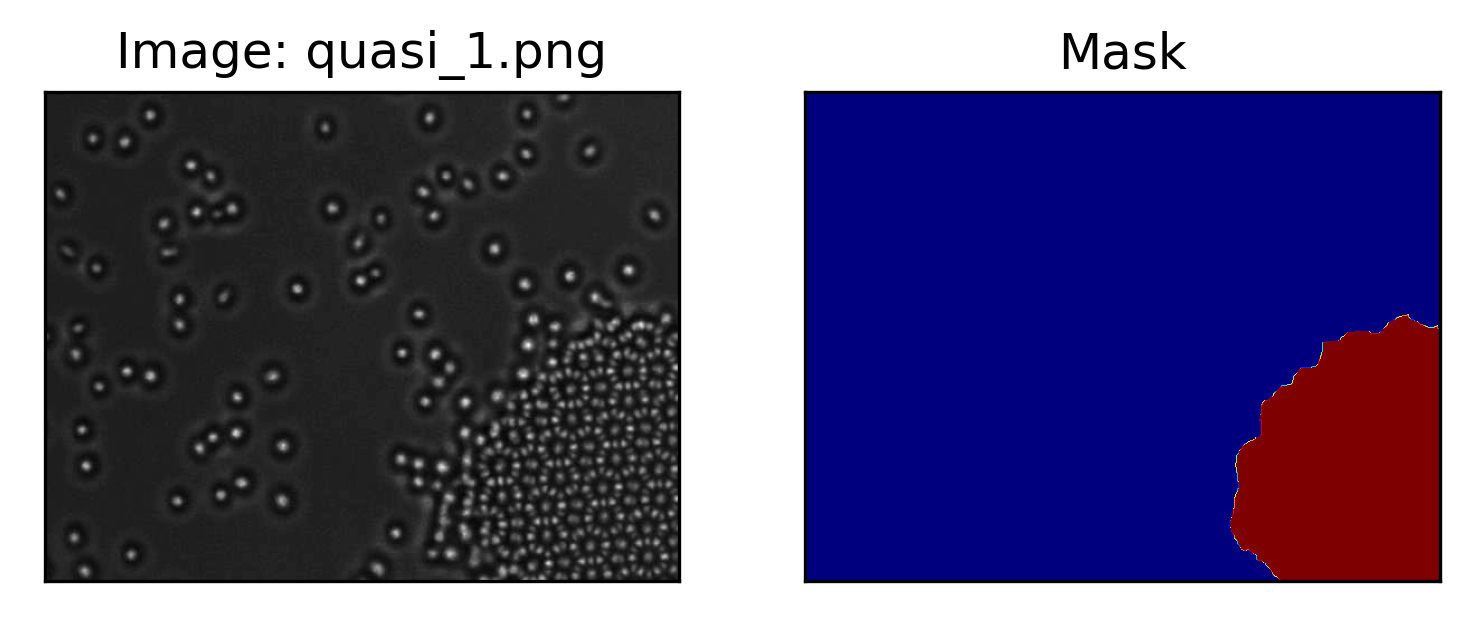

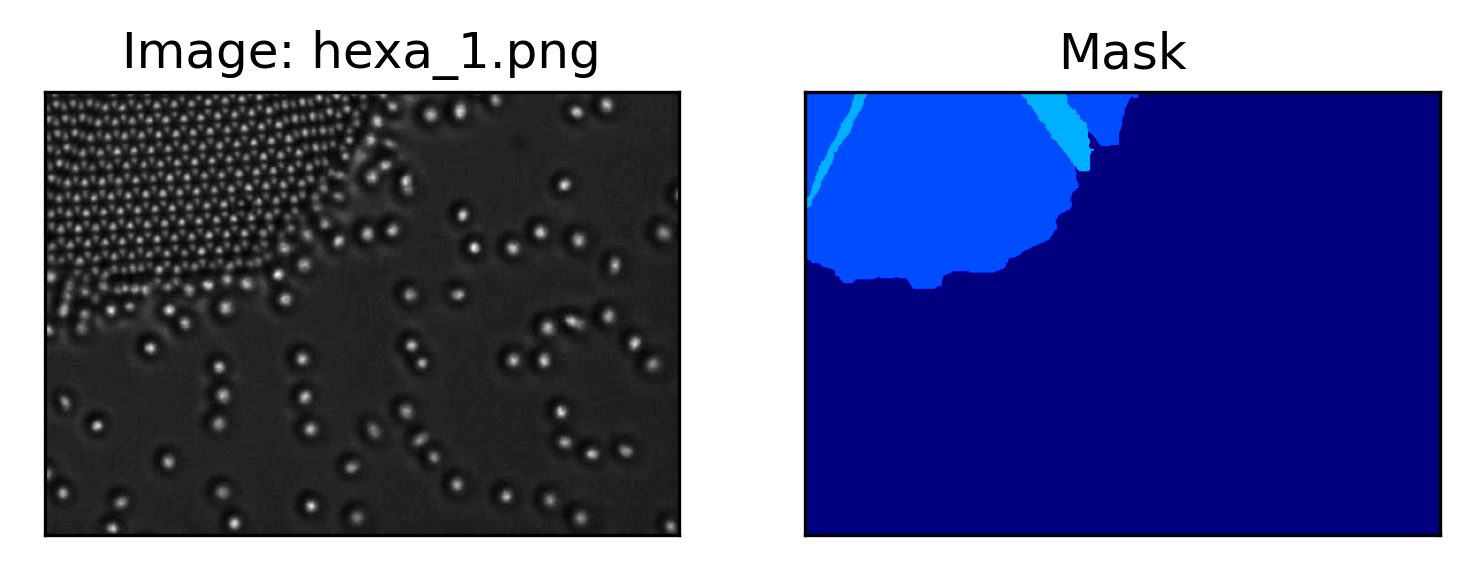

In [2]:
data_folder = '../data/phase_states'
mask_folder = '../data/phase_states/mask'
image_name_list = ['quasi_1.png', 'hexa_1.png']
#image_name_list = ['quasi_1.png', 'square_1.png', 'rect_2.png', 'hexa_1.png', 'hexa_2.png']

for image_name in image_name_list:
    im = cv.imread(os.path.join(data_folder, image_name), 0)
    mask_gt = cv.imread(os.path.join(mask_folder, image_name), 0)
    plt.subplot(121), plt.imshow(im, cmap='gray')
    plt.title('Image: ' + image_name), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(mask_gt, cmap=plt.cm.jet, vmax=10)
    plt.title('Mask'), plt.xticks([]), plt.yticks([])
    plt.show()
    

## 3. Detection of the particles

Detection of particles in the images and annotation by the mask color. Our detection is not good at all since we did not optimize at all, but as an instructive example it is good enough. 

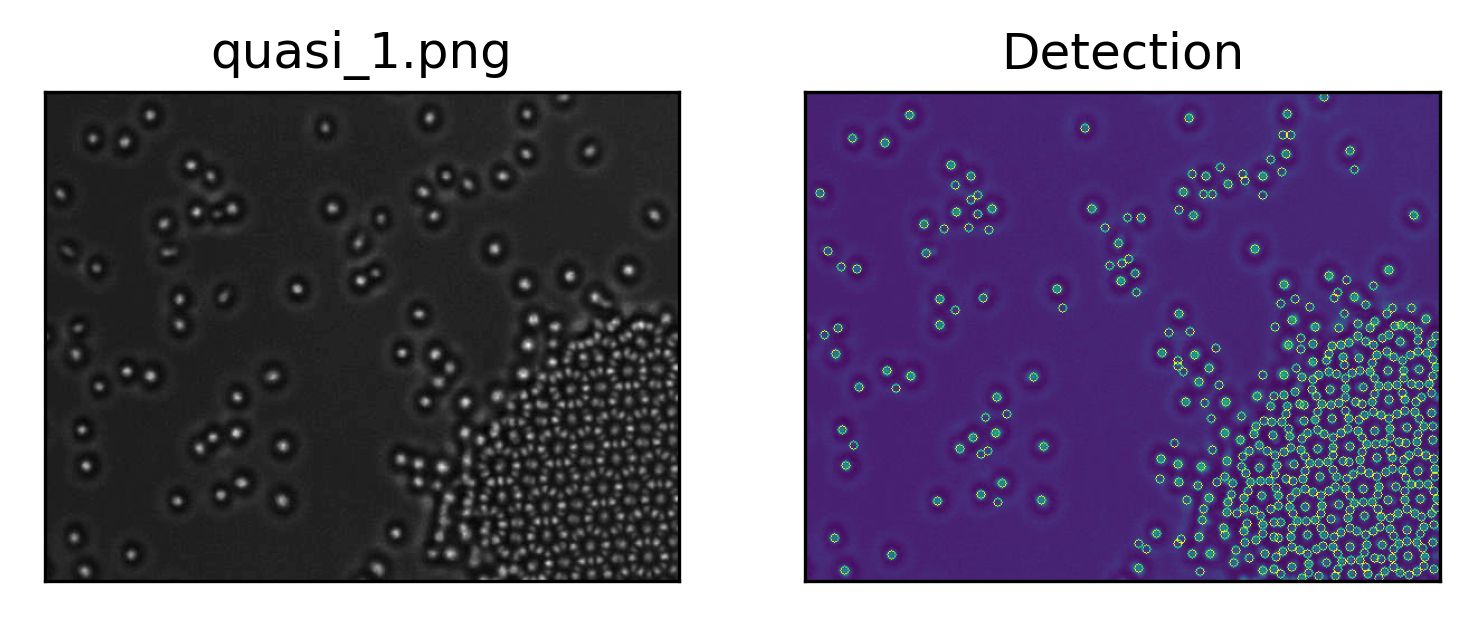

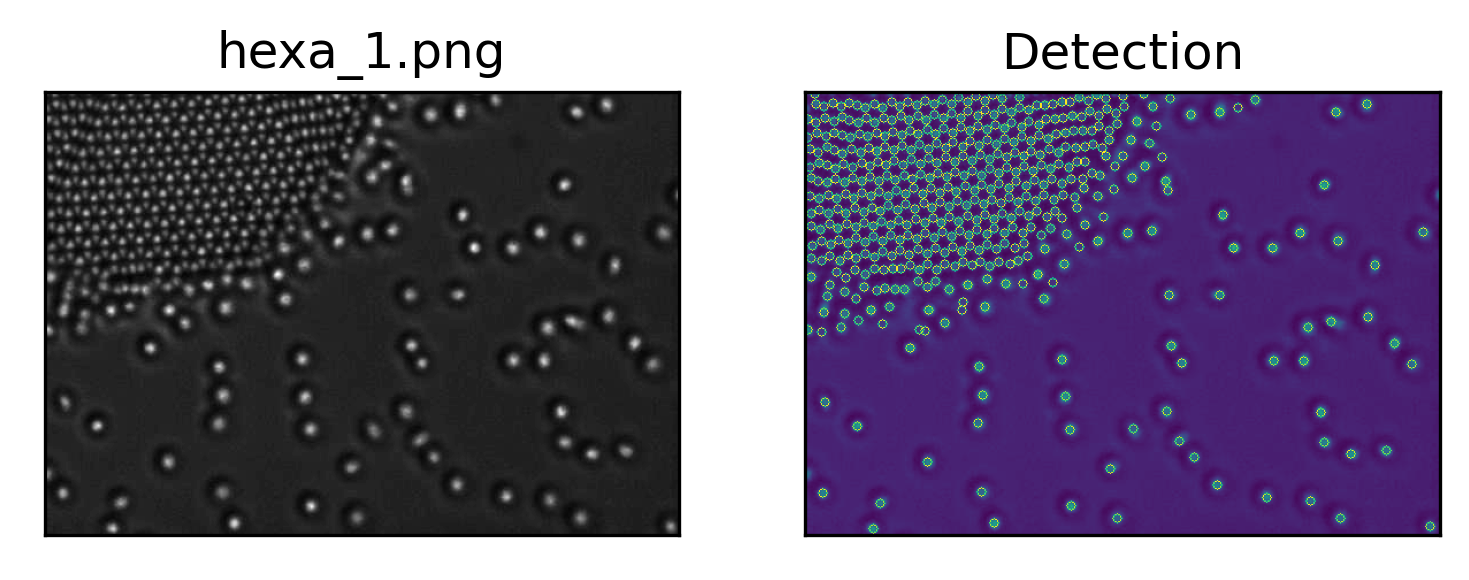

In [3]:
# Parameters
saturation_perc = 0.01
radius = 2
is_dark = 0
radius_show = 4

for image_name in image_name_list:
    im = cv.imread(os.path.join(data_folder, image_name), 0)
    mask_gt = cv.imread(os.path.join(mask_folder, image_name), 0)
    
    # Laplacian detector
    circle_list, im_gray, im_norm, im_blur = detection.detection(im, "Laplace", saturation_perc, radius, is_dark)
    im_circles = np.copy(im_gray)
    plots.draw_circles(circle_list, im_circles, radius=radius_show)

    # Plot the detected particles
    plt.subplot(121), plt.imshow(im, cmap='gray')
    plt.title(image_name), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(im_circles)
    plt.title('Detection'), plt.xticks([]), plt.yticks([])
    plt.show()

## 4. Compute or Load the features



In [4]:
%%debug
# Feature data
feature_folder = '../data/phase_states/features'
feature_file_name = 'features_2.csv'
do_read_feature_table = False

# Read or compute features
if do_read_feature_table:
    # Load training features from table'
    df_train = pd.read_csv(os.path.join(feature_folder, feature_file_name))
else:
    #util.my_comment('Load training images and save feature table')
    df_list = []
    for image_name in image_name_list:
        util.my_comment('Processing features: ' + image_name)
        im = cv.imread(os.path.join(data_folder, image_name), 0)
        mask_gt = cv.imread(os.path.join(mask_folder, image_name), 0)
        df, y = pr.extract_features(im, mask_gt)
        df['image_name'] = image_name
        df['gt'] = y
        df_list.append(df)

    df_train = pd.concat(df_list)
    df_train.to_csv(os.path.join(feature_folder, feature_file_name), index=False)

# Extract trainable features of the data
feature_list = [
    'area',
    'n_norm_NN',
    'n_NN',
    'distance_mean',
    'distance_std',
    'angle_mean',
    'angle_std',
    'NN_distance_mean',
    'NN_distance_std',
    'NN_angle_mean',
    'NN_angle_std',
    'Lindemann_5',
    'Lindemann_10',
    'Lindemann_20'
]
X = df_train.loc[:, feature_list]
y = df_train.loc[:, 'gt']


NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(3)<module>()



ipdb>  c


--------------------------------------------------------------------------------
Processing features: quasi_1.png
--------------------------------------------------------------------------------
---Detection of the particles in the image---
---Lindemann features---
---Voronoi diagram features---
---Delaunay triangulation features---
--------------------------------------------------------------------------------
Processing features: hexa_1.png
--------------------------------------------------------------------------------
---Detection of the particles in the image---
---Lindemann features---
---Voronoi diagram features---
---Delaunay triangulation features---


## 5. Training 

The amount of data we use is at this moment not sufficient, most lattice types are even not available.

### Support Vector Machine

Use the data to train an SVM

In [5]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

# Split dataset into training set and test set (same image, more like a validation set)
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

# SVM regularization parameter
C = 1.0
# Models
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=20000),
          svm.SVC(kernel='rbf', gamma=0.4, C=C))

# Model Accuracy: how often is the classifier correct?
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

util.my_comment('Train an SVM')
for clf in models:
    util.my_comment('Internal accuracy (unseen particles but from the same image)')

    util.my_sub_comment('Started training model')
    model = clf.fit(X_train, y_train)
    util.my_sub_comment('Finished training')
    print('')

    # Verify the accuracy of the model
    y_pred = clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test,y_pred))
    print('')
    print("Classification report:")
    print(metrics.classification_report(y_test,y_pred))
    print('')
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print('')



--------------------------------------------------------------------------------
Train an SVM
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Internal accuracy (unseen particles but from the same image)
--------------------------------------------------------------------------------
---Started training model---
---Finished training---

Confusion matrix:
[[87  2  0  5]
 [ 0 85  0 13]
 [ 0  5  0  4]
 [ 2 24  0 71]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        94
           2       0.73      0.87      0.79        98
           3       0.00      0.00      0.00         9
          10       0.76      0.73      0.75        97

    accuracy                           0.82       298
   macro avg       0.62      0.63      0.62       298
weighted avg       0.80      0.82      0.80       298


Accuracy:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier

Use the data to train an Random Forest

In [6]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Split dataset into training set and test set (same image, more like a validation set)
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

util.my_comment('Train an Random Forest Classifier')
clf = RandomForestClassifier(n_estimators=20, random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

util.my_comment('Internal accuracy (unseen particles but from the same image)')
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test,y_pred))
print('')
print("Classification report:")
print(metrics.classification_report(y_test,y_pred))
print('')
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('')



--------------------------------------------------------------------------------
Train an Random Forest Classifier
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Internal accuracy (unseen particles but from the same image)
--------------------------------------------------------------------------------
Confusion matrix:
[[87  1  0  6]
 [ 2 80  0 16]
 [ 0  6  1  2]
 [ 2  8  1 86]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        94
           2       0.84      0.82      0.83        98
           3       0.50      0.11      0.18         9
          10       0.78      0.89      0.83        97

    accuracy                           0.85       298
   macro avg       0.77      0.68      0.70       298
weighted avg       0.85      0.85      0.85       298


Accuracy: 0.8523489932885906



### Simple neural network in scikit-learn

Use the data to train a very simple Neural network

--------------------------------------------------------------------------------
Train an simple sklearn neural network
--------------------------------------------------------------------------------
Accuracy: 0.2181208053691275


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.7114093959731543
Accuracy: 0.7583892617449665
Accuracy: 0.761744966442953
Accuracy: 0.785234899328859
Accuracy: 0.7953020134228188
Accuracy: 0.7953020134228188
Accuracy: 0.802013422818792
Accuracy: 0.7919463087248322
Accuracy: 0.7986577181208053
Accuracy: 0.802013422818792
Accuracy: 0.8087248322147651
Accuracy: 0.8120805369127517
Accuracy: 0.8154362416107382
Accuracy: 0.8154362416107382
Accuracy: 0.8120805369127517
Accuracy: 0.8120805369127517
Accuracy: 0.8154362416107382
Accuracy: 0.8120805369127517
Accuracy: 0.8120805369127517
--------------------------------------------------------------------------------
Internal accuracy (unseen particles but from the same image)
--------------------------------------------------------------------------------
Confusion matrix:
[[89  0  0  5]
 [ 2 75  2 19]
 [ 0  4  0  5]
 [ 3 17  0 77]]

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        94
           2      

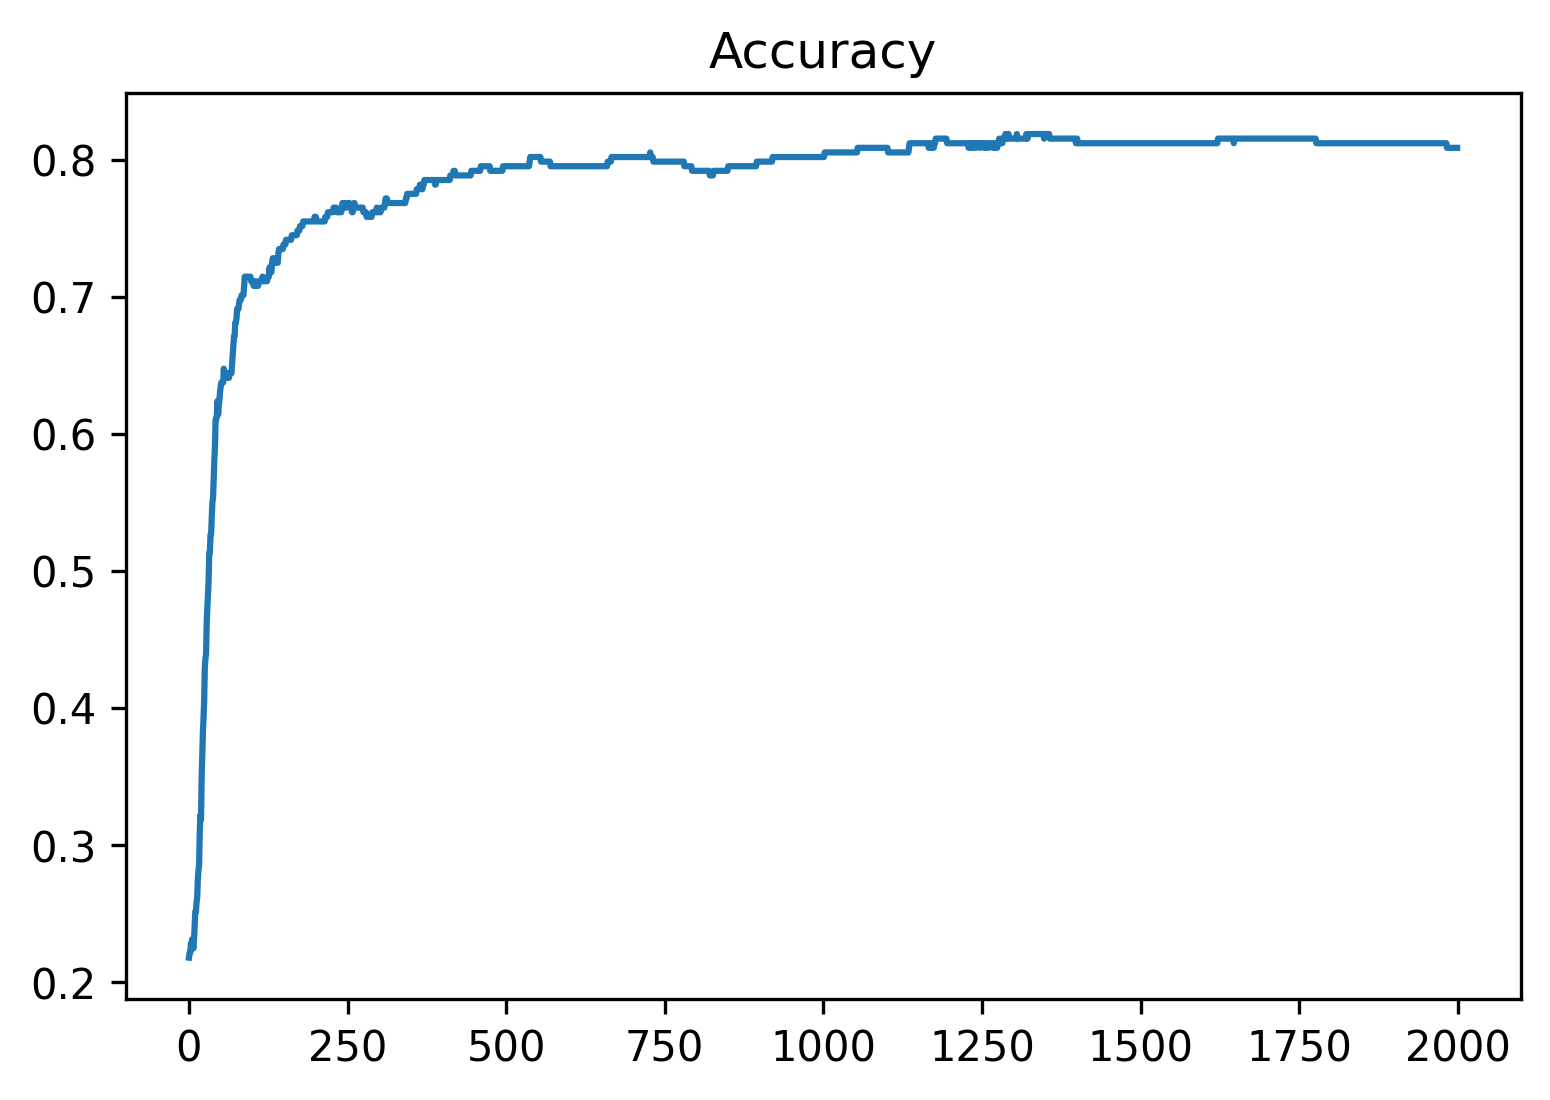

In [11]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Feature Scaling (should this be done separately on training and validation set???)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

# Split dataset into training set and test set (same image, more like a validation set)
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

# Random forest classifier
from sklearn.neural_network import MLPClassifier

util.my_comment('Train an simple sklearn neural network')
#clf = MLPClassifier(solver='adam', alpha=1e-5,
#    hidden_layer_sizes=(30,), random_state=1)

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter=1, warm_start=True)
accuracy_list = []
for i in range(2000):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)
    if i % 100 == 0:
        print("Accuracy:", acc)

# Model Accuracy: how often is the classifier correct?
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

util.my_comment('Internal accuracy (unseen particles but from the same image)')
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test,y_pred))
print('')
print("Classification report:")
print(metrics.classification_report(y_test,y_pred))
print('')
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('')

plt.subplot(111), plt.plot( accuracy_list )
plt.title('Accuracy')
plt.show()


## 6. Apply the model onto the testing data

TODO

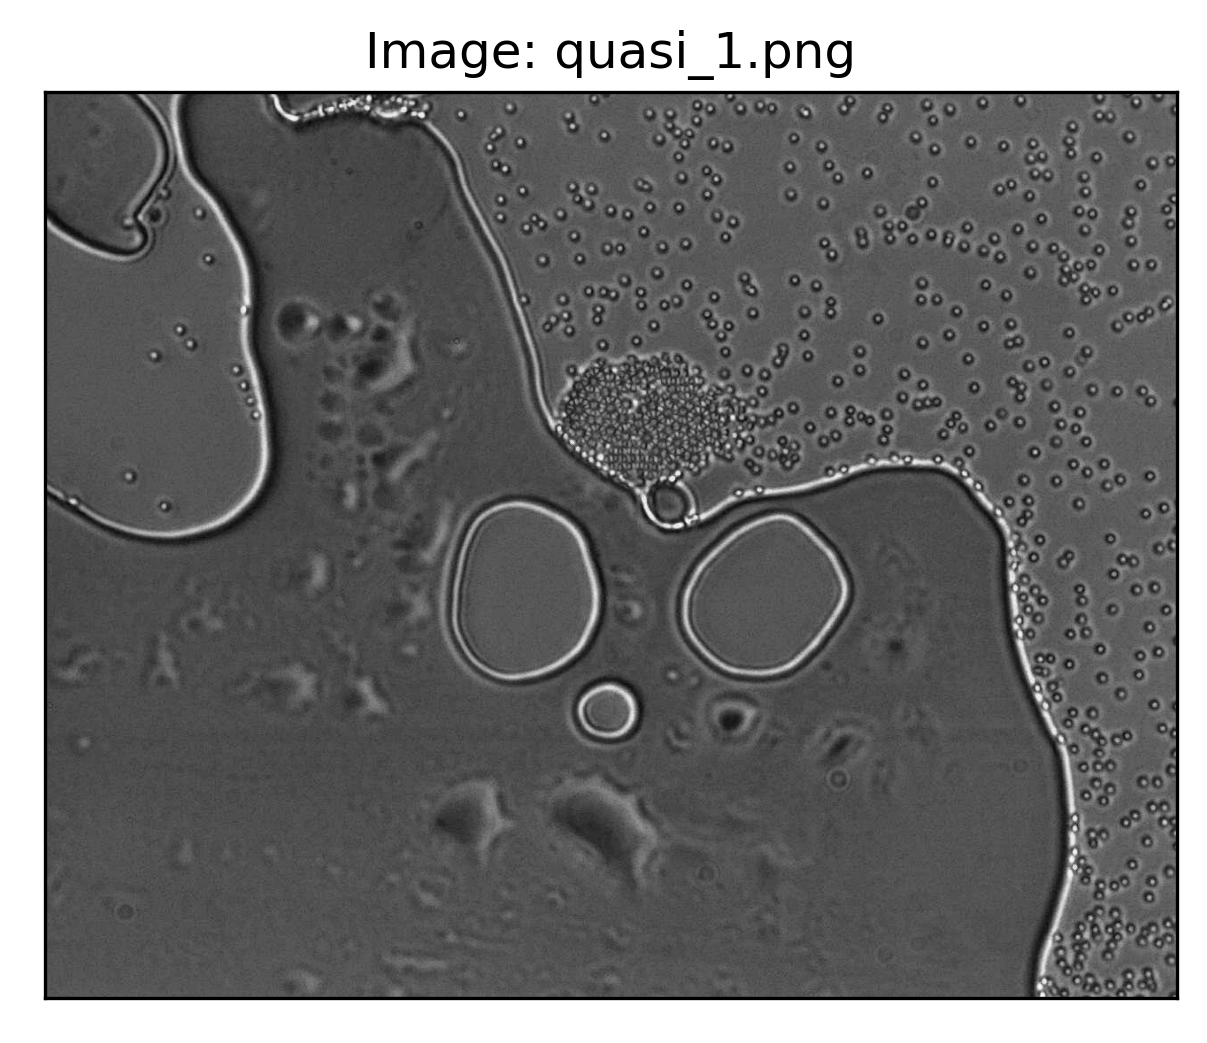

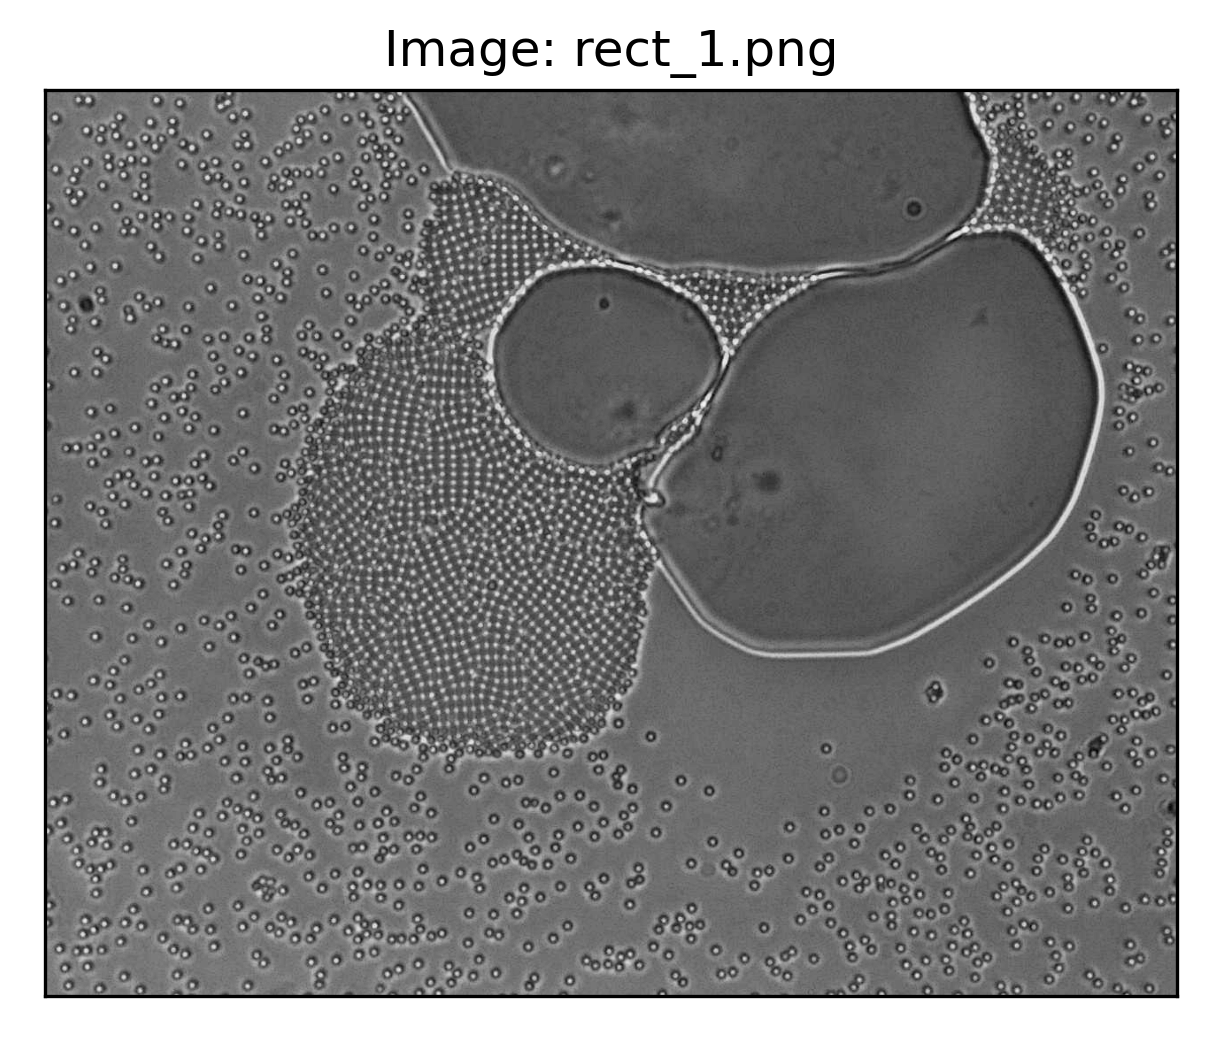

In [8]:
test_folder = '../data/phase_states/test'
test_name_list = ['quasi_1.png', 'rect_1.png']

for test_name in test_name_list:
    im = cv.imread(os.path.join(test_folder, test_name), 0)
    plt.subplot(111), plt.imshow(im, cmap='gray')
    plt.title('Image: ' + test_name), plt.xticks([]), plt.yticks([])
    plt.show()